In [32]:
import numpy as np
import pandas as pd
# import data
filepath = 'UNP.csv'
data = pd.read_csv(filepath)
data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,02-01-1980,3.010041,3.010041,1165973,3.052066,3.015294,1.078456
1,03-01-1980,2.947003,2.994281,1453896,2.994281,2.973269,1.063425
2,04-01-1980,2.978522,2.978522,1382510,3.025800,3.025800,1.082213
3,07-01-1980,3.010041,3.025800,1087448,3.052066,3.010041,1.076578
4,08-01-1980,2.899725,3.010041,1213563,3.036306,2.899725,1.037121


In [33]:
data.shape

(10830, 7)

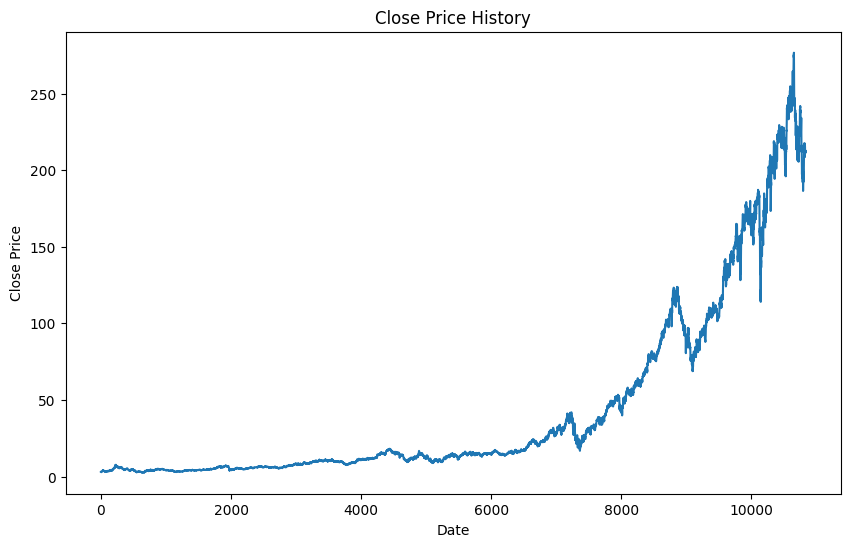

In [34]:
import matplotlib.pyplot as plt
# plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [35]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10830 entries, 0 to 10829
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10830 non-null  float64
dtypes: float64(1)
memory usage: 84.7 KB


In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\xionghz\AppData\Local\Temp\ipykernel_20636\3750275899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [37]:
price['Close'].shape

(10830,)

In [38]:
def split_data(stock,lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw)-lookback):
        data.append(data_raw[index:index+lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train,y_train,x_test,y_test]
    

In [39]:
lookback = 20
x_train,y_train,x_test,y_test = split_data(price,lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (8648, 19, 1)
y_train.shape =  (8648, 1)
x_test.shape =  (2162, 19, 1)
y_test.shape =  (2162, 1)


In [40]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

input_dim = 1  
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100


In [41]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()

        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))

        out = self.fc(out[:,-1,:])
        return out

In [42]:
model = LSTM(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim,num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.01)



In [43]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred,y_train)
    print("Epoch ",t,"MSE: ",loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.5480194091796875
Epoch  1 MSE:  0.3628195524215698
Epoch  2 MSE:  0.20259593427181244
Epoch  3 MSE:  0.05156370624899864
Epoch  4 MSE:  0.0664445161819458
Epoch  5 MSE:  0.07611129432916641
Epoch  6 MSE:  0.02800918184220791
Epoch  7 MSE:  0.015929730609059334
Epoch  8 MSE:  0.026354555040597916
Epoch  9 MSE:  0.036064330488443375
Epoch  10 MSE:  0.037491414695978165
Epoch  11 MSE:  0.03223298117518425
Epoch  12 MSE:  0.024561386555433273
Epoch  13 MSE:  0.018484385684132576
Epoch  14 MSE:  0.016313878819346428
Epoch  15 MSE:  0.01798364706337452
Epoch  16 MSE:  0.021363215520977974
Epoch  17 MSE:  0.023753050714731216
Epoch  18 MSE:  0.023680705577135086
Epoch  19 MSE:  0.021540017798542976
Epoch  20 MSE:  0.01879957690834999
Epoch  21 MSE:  0.016815319657325745
Epoch  22 MSE:  0.016166990622878075
Epoch  23 MSE:  0.016660166904330254
Epoch  24 MSE:  0.017682692036032677
Epoch  25 MSE:  0.018589897081255913
Epoch  26 MSE:  0.018955111503601074
Epoch  27 MSE:  0.018660

In [44]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))


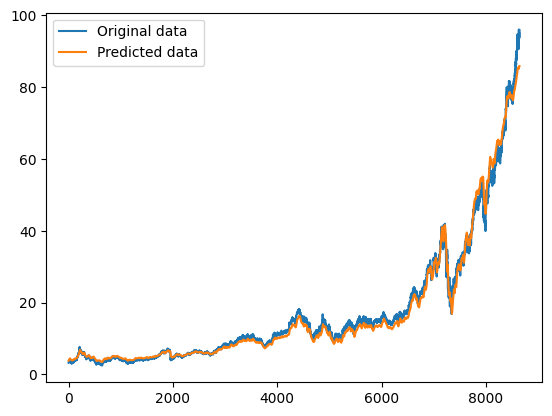

In [45]:
import matplotlib.pyplot as plt
plt.plot(original, label='Original data')
plt.plot(predict, label='Predicted data')
plt.legend()
plt.show()


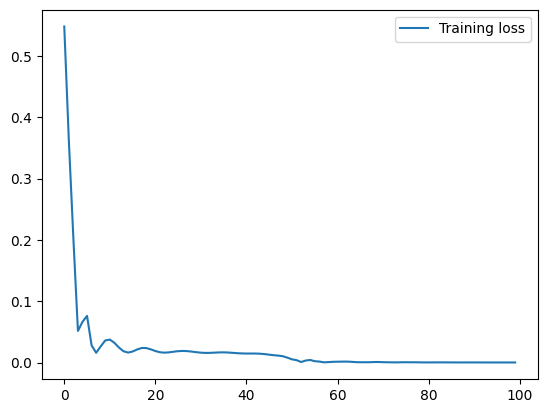

In [46]:
#plot the loss function
plt.plot(hist,label='Training loss')
plt.legend()
plt.show()
